In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random

In [19]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [20]:
import os
import time
from tensorflow.keras.layers import LSTM

# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 15

# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")

### model parameters

N_LAYERS = 2
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False

### training parameters

# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 50  # original - 500

# Amazon stock market
ticker = "AMZN"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [21]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)


def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_by_date (bool): whether we split the dataset into training/testing by date, setting it 
            to False will split datasets in a random way
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")

    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()

    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."

    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index

    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler

    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)

    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    
    # drop NaNs
    df.dropna(inplace=True)

    sequence_data = []
    sequences = deque(maxlen=n_steps)

    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])

    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)

    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)

    return result

In [22]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [23]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")

if not os.path.isdir("logs"):
    os.mkdir("logs")

if not os.path.isdir("data"):
    os.mkdir("data")

# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)

# save the dataframe
data["df"].to_csv(ticker_data_filename)

# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

In [24]:
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/50
82/82 [==============================] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.0274
Epoch 1: val_loss improved from inf to 0.00046, saving model to results\2023-07-25_AMZN-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
82/82 [==============================] - 31s 276ms/step - loss: 0.0023 - mean_absolute_error: 0.0274 - val_loss: 4.5941e-04 - val_mean_absolute_error: 0.0137
Epoch 2/50
82/82 [==============================] - ETA: 0s - loss: 7.8386e-04 - mean_absolute_error: 0.0194
Epoch 2: val_loss did not improve from 0.00046
82/82 [==============================] - 23s 279ms/step - loss: 7.8386e-04 - mean_absolute_error: 0.0194 - val_loss: 5.9128e-04 - val_mean_absolute_error: 0.0186
Epoch 3/50
82/82 [==============================] - ETA: 0s - loss: 6.7071e-04 - mean_absolute_error: 0.0182
Epoch 3: val_loss improved from 0.00046 to 0.00043, saving model to results\2023-07-25_AMZN-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-laye

82/82 [==============================] - ETA: 0s - loss: 6.1052e-04 - mean_absolute_error: 0.0185
Epoch 25: val_loss did not improve from 0.00041
82/82 [==============================] - 22s 274ms/step - loss: 6.1052e-04 - mean_absolute_error: 0.0185 - val_loss: 6.6375e-04 - val_mean_absolute_error: 0.0179
Epoch 26/50
82/82 [==============================] - ETA: 0s - loss: 5.5992e-04 - mean_absolute_error: 0.0177
Epoch 26: val_loss improved from 0.00041 to 0.00040, saving model to results\2023-07-25_AMZN-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
82/82 [==============================] - 22s 272ms/step - loss: 5.5992e-04 - mean_absolute_error: 0.0177 - val_loss: 4.0401e-04 - val_mean_absolute_error: 0.0124
Epoch 27/50
82/82 [==============================] - ETA: 0s - loss: 5.1441e-04 - mean_absolute_error: 0.0168
Epoch 27: val_loss did not improve from 0.00040
82/82 [==============================] - 23s 278ms/step - loss: 5.1441e-04 - mean_absolute_erro

Epoch 50/50
82/82 [==============================] - ETA: 0s - loss: 4.8428e-04 - mean_absolute_error: 0.0172
Epoch 50: val_loss did not improve from 0.00040
82/82 [==============================] - 22s 271ms/step - loss: 4.8428e-04 - mean_absolute_error: 0.0172 - val_loss: 5.0733e-04 - val_mean_absolute_error: 0.0144


In [38]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [39]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [40]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [41]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [42]:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [43]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

41/41 [==============================] - 2s 38ms/step


In [44]:
# predict the future price
future_price = predict(model, data)

1/1 [==============================] - 0s 41ms/step


In [45]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [46]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 15 days is 132.82$
huber_loss loss: 0.0004003913199994713
Mean Absolute Error: 2.337905859396586
Accuracy score: 0.9739663093415007
Total buy profit: 30863.240489900112
Total sell profit: 30443.902970850468
Total profit: 61307.14346075058
Profit per trade: 46.94268258862985


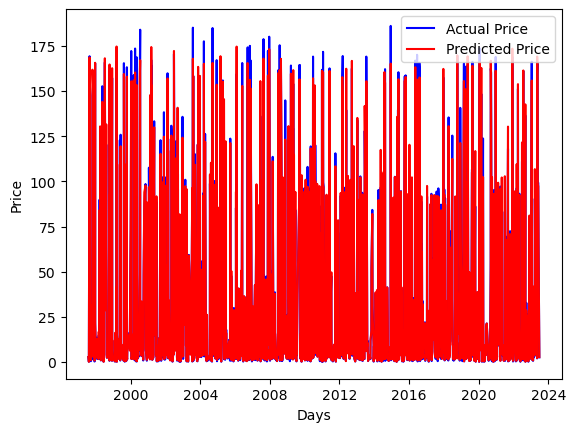

In [47]:
# plot true/pred prices graph
plot_graph(final_df)

In [48]:
final_df.head(20)

,open,high,low,close,adjclose,volume,ticker,adjclose_15,true_adjclose_15,buy_profit,sell_profit
1997-07-29,0.118229,0.125000,0.116667,0.123958,0.123958,96288000,AMZN,2.810072,2.786000,2.662042,0.0
1997-08-07,0.112500,0.113021,0.106250,0.108854,0.108854,40680000,AMZN,0.174469,0.184375,0.075521,0.0
1997-08-21,0.106771,0.108594,0.103646,0.105729,0.105729,12480000,AMZN,168.563232,169.201004,169.095275,0.0
1997-09-05,0.129167,0.133333,0.122917,0.125000,0.125000,38160000,AMZN,3.457759,3.928125,3.803125,0.0
1997-09-08,0.126563,0.151042,0.125000,0.150000,0.150000,112968000,AMZN,3.907664,3.436500,3.286500,0.0
1997-09-10,0.165625,0.166406,0.156250,0.165104,0.165104,77328000,AMZN,8.454350,8.549000,8.383896,0.0
1997-09-12,0.159375,0.184896,0.157813,0.184375,0.184375,66672000,AMZN,4.143369,3.051000,2.866625,0.0
1997-09-15,0.183333,0.183854,0.152604,0.154688,0.154688,111672000,AMZN,2.324706,2.547500,2.392812,0.0
1997-09-16,0.156250,0.177083,0.155990,0.167708,0.167708,128640000,AMZN,1.085497,0.511500,0.343792,0.0
1997-09-17,0.172917,0.175000,0.166667,0.170313,0.170313,52152000,AMZN,1.942695,2.366500,2.196187,0.0


In [49]:
final_df.tail(20)

,open,high,low,close,adjclose,volume,ticker,adjclose_15,true_adjclose_15,buy_profit,sell_profit
2023-01-31,101.160004,103.349998,101.139999,103.129997,103.129997,66527300,AMZN,1.195218,1.090000,0.000000,102.039997
2023-02-01,102.529999,106.239998,101.239998,105.150002,105.150002,80450100,AMZN,9.194204,9.063000,0.000000,96.087002
2023-02-09,101.320000,101.779999,97.570000,98.239998,98.239998,64622500,AMZN,4.063812,3.957000,0.000000,94.282998
2023-02-15,99.089996,101.169998,98.449997,101.160004,101.160004,47957600,AMZN,0.936731,0.709500,0.000000,100.450504
2023-02-22,95.099998,97.010002,94.800003,95.790001,95.790001,59534100,AMZN,25.335247,29.951500,0.000000,65.838501
2023-02-23,96.120003,96.430000,93.669998,95.820000,95.820000,48467000,AMZN,4.067680,2.293750,0.000000,93.526250
2023-03-14,93.830002,95.070000,92.709999,94.879997,94.879997,60912700,AMZN,42.074917,37.820000,0.000000,57.059998
2023-03-17,99.790001,100.660004,97.459999,98.949997,98.949997,87300200,AMZN,3.703170,3.278125,0.000000,95.671872
2023-03-23,100.430000,101.059998,97.620003,98.709999,98.709999,57559300,AMZN,15.414030,14.863000,0.000000,83.846999
2023-03-24,98.070000,98.300003,96.400002,98.129997,98.129997,56095400,AMZN,106.734009,90.391998,-7.737999,0.000000


In [51]:
# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)
print("process completed!")

process completed!
